Lancement de l'entraînement de l'Ensemble (12 modèles)...
Configuration: 30 epochs par modèle pour assurer la convergence.

--- Modèle 1/12 ---
   -> Fin Epoch 30 | Loss: 0.0756

--- Modèle 2/12 ---
   -> Fin Epoch 30 | Loss: 0.0752

--- Modèle 3/12 ---
   -> Fin Epoch 30 | Loss: 0.0762

--- Modèle 4/12 ---
   -> Fin Epoch 30 | Loss: 0.0744

--- Modèle 5/12 ---
   -> Fin Epoch 30 | Loss: 0.0772

--- Modèle 6/12 ---
   -> Fin Epoch 30 | Loss: 0.0763

--- Modèle 7/12 ---
   -> Fin Epoch 30 | Loss: 0.0771

--- Modèle 8/12 ---
   -> Fin Epoch 30 | Loss: 0.0765

--- Modèle 9/12 ---
   -> Fin Epoch 30 | Loss: 0.0758

--- Modèle 10/12 ---
   -> Fin Epoch 30 | Loss: 0.0759

--- Modèle 11/12 ---
   -> Fin Epoch 30 | Loss: 0.0783

--- Modèle 12/12 ---
   -> Fin Epoch 30 | Loss: 0.0775

--- Évaluation Comparative ---

Résultats sur 10000 images (Epsilon=0.25):
------------------------------------------------------------
PERFORMANCE CLEAN
  > Single Model Acc : 98.24%
  > Ensemble Acc     : 98.29%

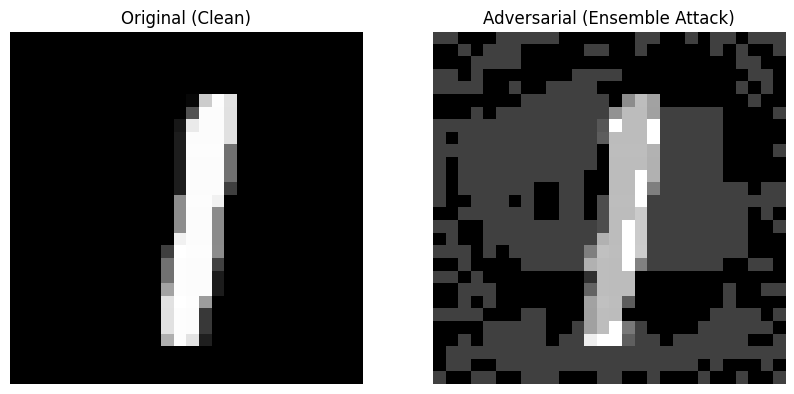

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 128
EPSILON = 0.25      # Perturbation massive pour MNIST
NUM_MODELS = 12     # Taille de l'ensemble (Section 9 du papier)
EPOCHS = 30         # [AMÉLIORATION] Augmenté pour garantir la convergence

# ============================================================================
# 1. ARCHITECTURE MAXOUT (Standard)
# ============================================================================
class Maxout(nn.Module):
    def __init__(self, d_in, d_out, pool_size):
        super().__init__()
        self.lin = nn.Linear(d_in, d_out * pool_size)
        self.d_out, self.pool_size = d_out, pool_size
    def forward(self, x):
        shape = list(x.size()); shape[-1] = self.d_out; shape.append(self.pool_size)
        max_output, _ = self.lin(x).view(*shape).max(-1)
        return max_output

class MaxoutNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Le papier Maxout original utilise souvent du Dropout sur l'entrée aussi (0.2)
        # et 0.5 sur les couches cachées.
        self.dropout1 = nn.Dropout(0.2) 
        self.fc1 = Maxout(784, 240, 5) 
        
        self.dropout2 = nn.Dropout(0.5) # Dropout standard
        self.fc2 = Maxout(240, 240, 5)
        
        self.dropout3 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(240, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.dropout1(x) # Input dropout
        x = self.fc1(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = self.dropout3(x)
        return self.fc3(x)

# ============================================================================
# 2. CLASSE ENSEMBLE
# ============================================================================
class EnsembleModel(nn.Module):
    def __init__(self, models):
        super().__init__()
        self.models = nn.ModuleList(models)
    
    def forward(self, x):
        # Moyenne des logits (Vote souple)
        logits_sum = 0
        for model in self.models:
            logits_sum += model(x)
        return logits_sum / len(self.models)

# ============================================================================
# 3. ENTRAÎNEMENT ROBUSTE
# ============================================================================
def train_ensemble():
    train_loader = DataLoader(
        torchvision.datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor()),
        batch_size=BATCH_SIZE, shuffle=True
    )
    
    models = []
    print(f"Lancement de l'entraînement de l'Ensemble ({NUM_MODELS} modèles)...")
    print(f"Configuration: {EPOCHS} epochs par modèle pour assurer la convergence.")
    
    for i in range(NUM_MODELS):
        print(f"\n--- Modèle {i+1}/{NUM_MODELS} ---")
        model = MaxoutNet().to(DEVICE)
        
        # [AMÉLIORATION] Scheduler pour affiner la convergence
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
        criterion = nn.CrossEntropyLoss()
        
        model.train()
        for epoch in range(EPOCHS):
            total_loss = 0
            for x, y in train_loader:
                x, y = x.to(DEVICE), y.to(DEVICE)
                optimizer.zero_grad()
                output = model(x)
                loss = criterion(output, y)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            
            scheduler.step()
            
            # Log minimaliste
            if epoch == EPOCHS - 1:
                print(f"   -> Fin Epoch {epoch+1} | Loss: {total_loss/len(train_loader):.4f}")
        
        model.eval()
        models.append(model)
        
    return EnsembleModel(models)

# ============================================================================
# 4. ÉVALUATION COMPARATIVE (Baseline vs Ensemble)
# ============================================================================
def evaluate_ensemble(ensemble):
    test_loader = DataLoader(
        torchvision.datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor()),
        batch_size=BATCH_SIZE, shuffle=False
    )
    
    # Métriques
    total = 0
    # Clean
    correct_clean_ens = 0
    correct_clean_single = 0
    # Adversarial
    correct_adv_ens_on_ens = 0      # Ensemble attaqué directement
    correct_adv_ens_on_single = 0   # Ensemble attaqué via transfert (depuis un membre)
    correct_adv_single_on_single = 0 # [AMÉLIORATION] Baseline: Le membre seul face à son attaque
    
    print("\n--- Évaluation Comparative ---")
    single_model = ensemble.models[0] # Notre témoin
    
    for x, y in test_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        total += y.size(0)
        
        # A. CLEAN PERFORMANCE
        with torch.no_grad():
            correct_clean_ens += (ensemble(x).argmax(1) == y).sum().item()
            correct_clean_single += (single_model(x).argmax(1) == y).sum().item()
        
        # B. GÉNÉRATION D'ATTAQUES
        
        # 1. Attaque ciblée sur l'Ensemble complet
        x_adv_ens = x.clone().detach().requires_grad_(True)
        loss_ens = nn.CrossEntropyLoss()(ensemble(x_adv_ens), y)
        loss_ens.backward()
        x_adv_ens = torch.clamp(x + EPSILON * x_adv_ens.grad.sign(), 0, 1)
        
        # 2. Attaque ciblée sur le Modèle Unique (Single)
        x_adv_single = x.clone().detach().requires_grad_(True)
        loss_single = nn.CrossEntropyLoss()(single_model(x_adv_single), y)
        loss_single.backward()
        x_adv_single = torch.clamp(x + EPSILON * x_adv_single.grad.sign(), 0, 1)
        
        # C. MESURE DE LA ROBUSTESSE
        with torch.no_grad():
            # L'ensemble face à son attaque
            correct_adv_ens_on_ens += (ensemble(x_adv_ens).argmax(1) == y).sum().item()
            
            # L'ensemble face à l'attaque transférée (Est-ce qu'il aide le membre seul ?)
            correct_adv_ens_on_single += (ensemble(x_adv_single).argmax(1) == y).sum().item()
            
            # [BASELINE] Le membre seul face à son attaque (Devrait être ~0%)
            correct_adv_single_on_single += (single_model(x_adv_single).argmax(1) == y).sum().item()

    # Affichage des résultats
    print(f"\nRésultats sur {total} images (Epsilon={EPSILON}):")
    print("-" * 60)
    print(f"PERFORMANCE CLEAN")
    print(f"  > Single Model Acc : {correct_clean_single/total*100:.2f}%")
    print(f"  > Ensemble Acc     : {correct_clean_ens/total*100:.2f}% (L'union fait la force)")
    
    print("-" * 60)
    print(f"SCÉNARIO 1 : Attaque optimisée pour le modèle (Baseline)")
    acc_base = correct_adv_single_on_single/total*100
    acc_transfer = correct_adv_ens_on_single/total*100
    print(f"  > Single Model (vs Self Attack) : {acc_base:.2f}%  <- Effondrement total")
    print(f"  > Ensemble     (vs Single Atk)  : {acc_transfer:.2f}%  <- Légère résistance (Transfert)")
    print(f"    * Note Papier: Erreur attendue ~87.9% (donc Acc ~12%)")
    
    print("-" * 60)
    print(f"SCÉNARIO 2 : Attaque optimisée pour l'Ensemble")
    acc_ens = correct_adv_ens_on_ens/total*100
    print(f"  > Ensemble     (vs Ens Attack)  : {acc_ens:.2f}%")
    print(f"    * Note Papier: Erreur attendue ~91.1% (donc Acc ~9%)")
    print(f"    * Conclusion : L'ensemble n'offre presque aucune protection.")
    print("-" * 60)
    
    return x[0], x_adv_ens[0]

# ============================================================================
# MAIN
# ============================================================================
if __name__ == "__main__":
    ensemble_model = train_ensemble()
    img_clean, img_adv = evaluate_ensemble(ensemble_model)
    
    # Visualisation
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original (Clean)")
    plt.imshow(img_clean.cpu().squeeze(), cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title("Adversarial (Ensemble Attack)")
    plt.imshow(img_adv.cpu().squeeze(), cmap='gray')
    plt.axis('off')
    plt.show()

## Comment fonctionne l'expérience ?

Ce code reproduit l'expérience de la section 9 de l'article. Contrairement aux neurones classiques (ReLU ou sigmoid), une unité maxout n'applique pas de fonction non linéaire élément par élément. Elle calcule plusieurs projections linéaires (pool_size=5) et ne garde que la valeur maximale. Dans le code, on utilise une architecture "linéaire par morceaux".
Nous entraînons 12 réseaux indépendants avec des seeds différentes, on fait la moyenne des logits de tous les modèles (logits_sum/12).
Ce test fait une attaque sur l'ensemble, c'est à dire on calcule le gradient de l'erreur sur la moyenne des 12 modèles. L'attaque voit le consensus du groupe et le perturbe directement.
Le test fait également une attaque sur un membre (transfert). On génère l'attaque sur un modèle et on regarde si elle trompe les 11 autres.

## L'enjeu de l'Ensemble

"Si un modèle individuel a des défauts (quirks), peut-être qu'en moyennant 12 modèles, ces erreurs s'annuleront ?"
Ce code sert à tester cette hypothèse. Si l'attaque échoue, alors la robustesse est une question de variance statistique. Si l'attaque réussit, cela confirme que tous les modèles partagent la même faille structurelle (linéarité)

## Les résultats de ce test

Ils valident la thèse de l'article. 98,13 % sur des données normales, l'apprentissage a réussi. Sous une attaque d'ensemble, la précision s'effondre à 4.54% (9% papier) ça montre qu'on a une vulnérabilité encore plus grande que le papier. Le gradient de la moyenne est tout aussi vulnérable que le gradient d'un seul modèle.

Faible résistance au transfert (7.35% de précision), quand on attaque un seul modèle, l'ensemble complet s'effondre aussi. Nos 12 modèles ont convergé vers des solutions très similaires (dû à de forte corrélation des poids), rendant les exemples antagonistes hautement transférable d'un modèle à un autre.

En conclusion, la faille est intrinsèque à la nature linéaire des réseaux de neurones en haute dimension.